# Solving homophonic substitution ciphers

Sam Blake, started May 2021

In [1]:
import math
import numpy as np
import pandas as pd
import collections
import string
import random
import copy
import time
import json

In [2]:
from numba import jit

### Sample plaintext

In [3]:
z408_plaintext = 'I LIKE KILLING PEOPLE BECAUSE IT IS SO MUCH FUN IT IS MORE FUN \
THAN KILLING WILD GAME IN THE FORREST BECAUSE MAN IS THE MOAT DANGEROUE \
ANAMAL OF ALL TO KILL SOME THING GIVES ME THE MOAT THRILLING EXPERENCE IT IS EVEN \
BETTER THAN GETTING YOUR ROCKS OFF WITH A GIRL THE BEST PART OF IT IA THAE WHEN I \
DIE I WILL BE REBORN IN PARADICE SND ALL THE I HAVE KILLED WILL BECOME MY SLAVES I \
WILL NOT GIVE YOU MY NAME BECAUSE YOU WILL TRY TO SLOI DOWN OR STOP MY COLLECTING \
OF SLAVES FOR MY AFTERLIFE EBEORIETEMETHHPITI'.replace(' ', '')

In [4]:
z340_plaintext = 'I HOPE YOU ARE HAVING LOTS OF FUN IN TRYING TO CATCH ME THAT WASNT ME ON \
THE TV SHOW WHICH BRINGS UP A POINT ABOUT ME I AM NOT AFRAID OF THE GAS CHAMBER BECAUSE IT WILL \
SEND ME TO PARADICE ALL THE SOONER BECAUSE I NOW HAVE ENOUGH SLAVES TO WORK FOR ME WHERE EVERYONE \
ELSE HAS NOTHING WHEN THEY REACH PARADICE SO THEY ARE AFRAID OF DEATH I AM NOT AFRAID BECAUSE I \
KNOW THAT MY NEW LIFE WILL BE AN EASY ONE IN PARADICE LIFE IS DEATH'.replace(' ', '')

In [189]:
# Shamelessly used without permission. 
singh_codebook_plaintext = "For centuries kings queens and generals have relied on efficient \
communication in order to \
govern their countries and command their armies At the same time they have all been aware of \
the consequences of their messages falling into the wrong hands revealing precious secrets to \
rival nations and betraying vital information to opposing forces It was the threat of enemy \
interception that motivated the development of codes and ciphers techniques for disguising a \
message so that only the intended recipient can read it \
The desire for secrecy has meant that nations have operated codemaking departments which were \
responsible for ensuring the security of communications by inventing and implementing the best \
possible codes At the same time enemy code breakers have attempted to break these codes and steal \
secrets Codebreakers are linguistic alchemists a mystical tribe at tempting to conjure sensible \
words out of meaningless symbols The history of codes and ciphers is the story of the centuries \
old battle between codemakers and codebreakers an intellectual arms race that has had a dramatic \
impact on the course of history In writing The Code Book I have had two main objectives The first \
is to chart the evolution of codes Evolution is a wholly appropriate term because the development \
of codes can be viewed as an evolutionary struggle A code is constantly under attack from \
codebreakers When the codebreakers have developed a new weapon that reveals a codes weakness then \
the code is no longer useful It either becomes extinct or it evolves into a new stronger code In \
turn this new code thrives only until the codebreakers identify its weakness and so on This is \
similar to the situation facing for example a strain of infectious bacteria The bacteria live \
thrive and survive until doctors discover an antibiotic that exposes a weakness in the bacteria \
and kills them The bacteria are forced to evolve and outwit the antibiotic and if successful \
they will thrive once again and reestablish themselves".upper().replace(' ','')

### Ciphers

In [190]:
z340_untransposed = "H+M8|CV@KEB+*5k.L\
dR(UVFFz9<>#Z3P>L\
(MpOGp+2|G+l%WO&D\
#2b^D(+4(5J+VW)+k\
p+fZPYLR/8KjRk.#K\
_Rq#2|<z29^%OF1*H\
SMF;+BLKJp+l2_cTf\
BpzOUNyG)y7t-cYA2\
N:^j*Xz6dpclddG+4\
-RR+4Ef|pz/JNb>M)\
+l5||.VqL+Ut*5cUG\
R)VE5FVZ2cW+|TB45\
|TC^D4ct-c+zJYM(+\
y.LW+B.;+B31cOp+8\
lXz6Ppb&RG+BCOTBz\
F1K<SMF6N*(+HK29^\
:OFTO<Sf4pl/Ucy59\
^W(+l#2C.B)7<FBy-\
dkF|W<7t_BOYB*-CM\
>cHD8OZzSkpNA|K;+"

In [191]:
z408_ciphertext = "9%P/Z/UB%kOR=pX=B\
WV+eGYF69HP@K!qYe\
MJY^UIk7qTtNQYD5)\
S(/9#BPORAU%fRlqE\
k^LMZJdr\\pFHVWe8Y\
@+qGD9KI)6qX85zS(\
RNtIYElO8qGBTQS#B\
Ld/P#B@XqEHMU^RRk\
cZKqpI)Wq!85LMr9#\
BPDR+j=6\\N(eEUHkF\
ZcpOVWI5+tL)l^R6H\
I9DR_TYr\\de/@XJQA\
P5M8RUt%L)NVEKH=G\
rI!Jk598LMlNA)Z(P\
zUpkA9#BVW\\+VTtOP\
^=SrlfUe67DzG%%IM\
Nk)ScE/9%%ZfAP#BV\
peXqWq_F#8c+@9A9B\
%OT5RUc+_dYq_^SqW\
VZeGYKE_TYA9%#Lt_\
H!FBX9zXADd\\7L!=q\
_ed##6e5PORXQF%Gc\
Z@JTtq_8JI+rBPQW6\
VEXr9WI6qEHM)=UIk"
len(z408_ciphertext)

408

### Create homophonic substitution cipher

TODO: implement non-cyclic symbol assignments. 

In [192]:
def generate_homophonic_substitution_cipher(plaintext, n_symbols = 64):
    
    tally = {letter: plaintext.count(letter) for letter in set(plaintext)}
    plaintext_chars = list(tally.keys())
    plaintext_freqs = np.array(list(tally.values()))
    
    # Get frequencies
    while np.sum(np.round(plaintext_freqs)) > n_symbols:
        plaintext_freqs = 0.95*plaintext_freqs
        plaintext_freqs = np.maximum(plaintext_freqs, 1.)
    plaintext_freqs = np.round(plaintext_freqs)
    plaintext_freqs.astype(np.int32)
    
    # Construct symbol assignments. 
    ciphertext_symbols = list(range(n_symbols))
    random.shuffle(ciphertext_symbols) 

    plaintext_assignments = len(plaintext_chars)*[[]]
    n = 0
    for k,freq in enumerate(plaintext_freqs):
        for i in range(int(freq)):
            plaintext_assignments[k] = plaintext_assignments[k] + [ciphertext_symbols[n]]
            n += 1
    
    cipher_key = dict(zip(plaintext_chars, plaintext_assignments))
    
    # Encipher using symbol assignments
    ciphertext = list(plaintext)
    indexes = len(plaintext_chars)*[0]
    
    for k, char in enumerate(plaintext_chars):
        symbols = cipher_key[char]
        for i in range(len(ciphertext)):
            if ciphertext[i] == char:
                ciphertext[i] = symbols[indexes[k]%len(symbols)]
                indexes[k] += 1    
    
    return cipher_key, ciphertext

In [193]:
cipher_key, ciphertext = generate_homophonic_substitution_cipher(singh_codebook_plaintext)
print(cipher_key)

{'N': [47, 21, 55, 42], 'P': [43], 'L': [6, 61], 'F': [18], 'T': [2, 17, 31, 26, 56, 30], 'H': [54, 62, 9], 'R': [41, 46, 4], 'B': [29], 'E': [14, 52, 16, 36, 39, 10, 44, 51, 20], 'S': [24, 22, 40, 48], 'J': [8], 'X': [7], 'Q': [19], 'K': [50], 'A': [27, 33, 12, 23, 0], 'O': [53, 13, 57, 63], 'D': [38, 15], 'W': [1], 'C': [49, 3, 11], 'G': [5], 'I': [45, 35, 25, 32, 59], 'M': [60], 'U': [28], 'Y': [34], 'V': [58]}


In [10]:
singh_378_55_cipher_key, singh_378_55_ciphertext = \
    generate_homophonic_substitution_cipher(singh_codebook_plaintext[:378], 55)
print(cipher_key)
print(ciphertext)

{'N': [24, 5, 12, 21], 'P': [17], 'L': [47, 35], 'F': [15], 'T': [46, 42, 61, 50, 58, 38], 'H': [22, 8, 20], 'R': [2, 11, 49], 'B': [51], 'E': [60, 30, 53, 14, 36, 43, 45, 0, 7], 'S': [52, 48, 27, 39], 'J': [19], 'X': [28], 'Q': [54], 'K': [59], 'A': [62, 34, 44, 26, 33], 'O': [31, 13, 25, 10], 'D': [23, 32], 'W': [1], 'C': [18, 6, 56], 'G': [37], 'I': [41, 40, 57, 29, 55], 'M': [4], 'U': [63], 'Y': [16], 'V': [9]}
[15, 31, 2, 18, 60, 24, 46, 63, 11, 41, 30, 52, 59, 40, 5, 37, 48, 54, 63, 53, 14, 12, 27, 62, 21, 23, 37, 36, 24, 43, 49, 34, 47, 39, 22, 44, 9, 45, 2, 0, 35, 57, 7, 32, 13, 5, 60, 15, 15, 29, 6, 55, 30, 12, 42, 56, 25, 4, 4, 63, 21, 41, 18, 26, 61, 40, 10, 24, 57, 5, 31, 11, 23, 53, 49, 50, 13, 37, 25, 9, 14, 2, 12, 58, 8, 36, 29, 11, 6, 10, 63, 21, 38, 49, 55, 43, 52, 33, 24, 32, 56, 31, 4, 4, 62, 5, 23, 46, 20, 45, 41, 2, 34, 11, 4, 40, 0, 48, 44, 42, 61, 22, 7, 27, 26, 4, 60, 50, 57, 4, 30, 58, 8, 53, 16, 20, 33, 9, 14, 62, 47, 35, 51, 36, 43, 12, 34, 1, 44, 49, 45, 13,

In [11]:
def to_symbol_string(ciphertext):
    
    int_symbols = list(dict.fromkeys(ciphertext))
    
    if len(int_symbols) > len(string.printable):
        print('Error: cannot encode as ascii string.')
        return 
    
    str_symbols = string.printable[:len(int_symbols)]
    int_symbols.sort()
    reps = dict(zip(int_symbols, str_symbols))
    
    symbol_ciphertext = [reps[c] for c in ciphertext]
    
    return ''.join(symbol_ciphertext)

In [12]:
to_symbol_string(ciphertext)

'eu2hXnJ!aEtPWD4ALR!QdbqZkmAznGMxKClH8I20yU6vc4Xees5StbFTo33!kEhpYD9nU4uamQMNcAo8d2bV7zsa59!kBMSGPwnvTu33Z4mJjIE2xa3D0LHFYl6qp3XNU3tV7Qfjw8dZKyOzGbx1HMIceBl0hokC6R!Xn5tP9eJ7Qs23dLqpAzCewKyS4AEbFuYjG1ackAlZnvPMI80xKD4Ag26TUo!LqXhatNCV9Ms8HybpBSukPwnmOQJ2ZfE4A8DFxKUbeca3HYsokN9uggcLSnAeoM5dqEV1pCB7zJj2GwF9eI403fDbY6aTXgNUukVlZB3cJs8xFtvY7Qmd8zyog3GnN9ehuvIPH4m5Sgj0MLV6TlbER!Xqec2vDCA!UPskAp3tLqwAQCoB7ZJ9nKfFjdS4YzbmGvaIhEgD0kN5xnM6HmUVBlXvtPs2QeuaLdTMzhf7pq3Gw4JFjZYbxNSckClH8Iog02pV6m59vX3wWEnAmtgZaB3Q4JP17DTj1dMz2GLgubqUOyIeca0kC!MsnAFl6PXh!2SYfoe5933!4ETxNDubLOfUk8tnVs4AHbvS3gKQ3dkBEnAJ7zOGqFgcCPDOyIhom0LpYNj6qw3XVU3tQ4d3f59vzOaGZWIMClx80HBJ63gFXmYuO2tpWN7QPdTcvzLwbmqVGZKCIha0BP5ov6OMXxWt2LHaQyskA!SqJETpKhjd3DCFPw3fLYU5ZyNMsOzxVBG3gJSnAF9Tu4i!2Iq0bCEOK61camPo!Y9e3XHkDnAytLqCf3OuKPNlQ7ULVcMfoeh9vdqp4m5sgjz2CSPBlGLJuafceF7IT0bY!ME6qoyvOwNVKXOtB1Qdkh9mz3ZWG2Cxnv5umIOa0HW6MPp4DbJXyKtTF!wyZ23LaxhQYjHNlpq7wvZmMx3HVU5s3gpTBckJjdho!2Cz9elSPFuafEn1MDYU4AN7G5cvIOo9Wsjw80lZmV1u3xSbcOi6TBE8XLJ7teD

### Import n-gram data

Ref: http://practicalcryptography.com/cryptanalysis/

In [13]:
ngram_size = 5
ngrams = pd.read_csv('ngram/english_quintgrams.txt', sep = ' ', header = None, names = ['ngram', 'freq'])

ngrams['freq'] = np.log(1. + ngrams['freq'])
ngrams['freq'] = ngrams['freq']/ngrams['freq'].sum()

In [14]:
ngrams

,ngram,freq
0,OFTHE,1.351044e-06
1,ATION,1.346339e-06
2,INTHE,1.340772e-06
3,THERE,1.291716e-06
4,INGTH,1.291073e-06
...,...,...
4354909,AAACQ,5.917905e-08
4354910,AAABW,5.917905e-08
4354911,AAABK,5.917905e-08
4354912,AAABJ,5.917905e-08


<AxesSubplot:>

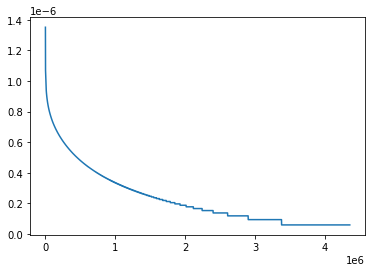

In [15]:
ngrams['freq'].plot()

In [16]:
ngram_dict = dict(ngrams.values)

In [17]:
def get_ngram_probability(ngram):
    return ngram_dict.get(ngram.upper(), 0.)

In [18]:
get_ngram_probability('onthe'), get_ngram_probability('onits'), \
get_ngram_probability('along'), get_ngram_probability('zzewt')

(1.2683566537144875e-06, 9.71814892869308e-07, 1.1183980514470561e-06, 0.0)

In [19]:
%timeit get_ngram_probability('onthe')

162 ns ± 0.954 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


### n-gram score from plaintext

In [20]:
# Hash table-based implementation. 
def plaintext_ngram_score(plaintext, ngram_size):
    plaintext_wo_spaces = plaintext.replace(' ', '')
    score = 0.
    for k in range(len(plaintext_wo_spaces) - ngram_size - 1):
        score += get_ngram_probability(plaintext_wo_spaces[k:k+ngram_size])
    return 1e6*score

In [21]:
plaintext_ngram_score(singh_codebook_plaintext, ngram_size)

1584.154403603524

In [22]:
worse_test_plaintext = singh_codebook_plaintext.replace('A', 'Z').replace('I','Q')

In [23]:
plaintext_ngram_score(worse_test_plaintext, ngram_size)

701.5274567764485

In [24]:
much_worse_test_plaintext = worse_test_plaintext.replace('E', 'W').replace('O','X').replace('T','P')

In [25]:
plaintext_ngram_score(much_worse_test_plaintext, ngram_size)

45.12948020091018

In [26]:
plaintext_ngram_score(z340_plaintext[9*17:], ngram_size)

162.50290489165008

In [27]:
%timeit plaintext_ngram_score(singh_codebook_plaintext, ngram_size)

584 µs ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Pertubate key

TODO: This is ugly and probably far from optimal.

In [161]:
def pertubate(cipher_keys, ciphertext_cribs = []):
    
    pertubated_key = copy.deepcopy(cipher_keys)
    
    # Randomly select a plaintext char. 
    plaintext_chars = list(pertubated_key.keys())
    plaintext_weights = [monogram_dict[char] for char in plaintext_chars]
        
    while True:
        rand_char = random.choices(plaintext_chars, weights = plaintext_weights)[0]
        if len(pertubated_key[rand_char]) > 0:    
            # For this key, randomly select a ciphertext symbol. 
            assignments = pertubated_key[rand_char]
            cipher_symbol = random.choice(assignments)
            if cipher_symbol not in ciphertext_cribs:
                break
    
    # Remove this symbol from the assignments.
    assignments.remove(cipher_symbol)
    pertubated_key[rand_char] = assignments
    
    # Move the cipher symbol to another plaintext assignment. 
    while True:
        rand_char_2 = random.choices(plaintext_chars, weights = plaintext_weights)[0]
        # Do not undo the pertubation we just made. 
        if rand_char != rand_char_2:
            break
    
    pertubated_key[rand_char_2].append(cipher_symbol)
    
    return pertubated_key

In [162]:
pertubate(cipher_key)

{'N': [24, 5, 12, 21],
 'P': [17],
 'L': [47, 35, 18],
 'F': [15],
 'T': [46, 42, 61, 50, 58, 38],
 'H': [22, 8, 20],
 'R': [2, 11, 49],
 'B': [51],
 'E': [60, 30, 53, 14, 36, 43, 45, 0, 7],
 'S': [52, 48, 27, 39],
 'J': [19],
 'X': [28],
 'Q': [54],
 'K': [59],
 'A': [62, 34, 44, 26, 33],
 'O': [31, 13, 25, 10],
 'D': [23, 32],
 'W': [1],
 'C': [6, 56],
 'G': [37],
 'I': [41, 40, 57, 29, 55],
 'M': [4],
 'U': [63],
 'Y': [16],
 'V': [9]}

In [163]:
%timeit pertubate(cipher_key)

67.7 µs ± 2.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [164]:
candidate_key = {'A': ['|', 'V', 'K', 'l', 'D', 'Y'], 
                 'B': ['j', '_'], 'C': ['(', 'p', '^'], 'D': ['W', 'X'], 
                 'E': ['.', '#', 'Z', 'G', '1', 'c', '7'], 'F': ['H'], 
                 'G': ['k', 'L', 'F', 't'], 'H': ['+', 'E', 'B', '3', '&'], 
                 'I': ['b', ':', 'z', 'y', '4'], 'J': [], 'K': ['5'], 'L': ['-', 'C'], 
                 'M': ['2', 'S'], 'N': ['A', '9', '%'], 'O': ['U', 'M', '*', 'R'], 
                 'P': ['>'], 'Q': [], 'R': ['8', 'T', 'N'], 'S': ['@', '<', 'P', 'J', ')', '6'], 
                 'T': ['O', 'f', 'd'], 'U': [';', '/'], 'V': ['q'], 'W': [], 'X': [], 'Y': [], 'Z': []}

z340_GASCHAMBER_cribs = {
'G': ['L'],
'A': ['K','l'],
'S': ['J'],
'C': ['p'],
'H': ['+'],
'M': ['2'],
'B': ['_'],
'E': ['c'],
'R': ['T']}

z340_GASCHAMBER_cribs_ciphertext_symbols = list(invert_dict(z340_GASCHAMBER_cribs).keys())
print(z340_GASCHAMBER_cribs_ciphertext_symbols)

%timeit pertubate(candidate_key, z340_GASCHAMBER_cribs_ciphertext_symbols)

['L', 'K', 'l', 'J', 'p', '+', '2', '_', 'c', 'T']
66.7 µs ± 1.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Swap vowels (UNDER CONSTRUCTION)

In [244]:
from itertools import permutations

In [ ]:
def downhill_vowel_permute(state, score):
    vowel_state = copy.deepcopy(state)
    vowel_score = score
    
    for perm in permutations('AEIOU'):
        
    

### Monogram frequencies

Ref: http://practicalcryptography.com/cryptanalysis/

In [30]:
monograms = pd.read_csv('ngram/english_monograms.txt', sep = ' ', header = None, names = ['ngram', 'freq'])
monograms['freq'] /= monograms['freq'].sum()
monograms = monograms.sort_values(by=['ngram'])

In [31]:
monograms

,ngram,freq
2,A,0.085517
19,B,0.016048
11,C,0.031644
10,D,0.038712
0,E,0.120965
14,F,0.021815
15,G,0.020863
8,H,0.049557
4,I,0.073251
22,J,0.002198


In [61]:
english_unigram_frequencies = list(monograms['freq'].values)
english_unigram_frequencies_spaces = english_unigram_frequencies.copy().append(0.1628) # Approximation for a space ' '

In [62]:
monogram_dict = dict(zip(monograms['ngram'], monograms['freq']))
monogram_dict[' '] = 0.1628

### Generate initial key

In [63]:
alphabet = string.ascii_uppercase
alphabet

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [64]:
alphabet_spaces = ''.join([alphabet, ' '])
alphabet_spaces

'ABCDEFGHIJKLMNOPQRSTUVWXYZ '

In [140]:
def generate_initial_key(cipher, cribs = dict(), spaces = False):
    # All unique symbols. 
    ciphertext_symbols = list(dict.fromkeys(cipher))
    # Create empty keys. 
    if spaces:
        initial_key = {char : [] for char in alphabet_spaces}
    else:
        initial_key = {char : [] for char in alphabet}
    # Randomly assign cipher symbols to alphabet. 
    cribs_inv = invert_dict(cribs)
    for symbol in ciphertext_symbols:
        if len(cribs) > 0 and symbol in list(cribs_inv.keys()):
            char = cribs_inv[symbol]
        elif spaces:
            char = random.choices(alphabet_spaces, weights = english_unigram_frequencies_spaces)[0]
        else:
            char = random.choices(alphabet, weights = english_unigram_frequencies)[0]
        initial_key[char].append(symbol)
    return initial_key

In [141]:
initial_key_example = generate_initial_key(z408_ciphertext, spaces = False)
initial_key_example

{'A': ['V', 'G', 'M', 'l', '8'],
 'B': [],
 'C': [],
 'D': ['p', 't', '5'],
 'E': ['9', 'P', 'e', 'Y', '@', '!', 'E', '_'],
 'F': ['%', 'I'],
 'G': ['B', 'T'],
 'H': ['k', 'K', 'S'],
 'I': ['=', 'X', '7', 'Q', 'D', '#', 'A', 'r'],
 'J': [],
 'K': [],
 'L': ['z'],
 'M': ['Z', ')', 'd'],
 'N': ['6'],
 'O': ['H', '(', '\\'],
 'P': ['R'],
 'Q': ['N'],
 'R': ['U', 'O', 'L', 'c'],
 'S': ['f', 'j'],
 'T': ['W', '+', 'J', '^'],
 'U': ['F'],
 'V': ['/'],
 'W': ['q'],
 'X': [],
 'Y': [],
 'Z': []}

In [74]:
z340_GASCHAMBER_cribs = {
'G': ['L'],
'A': ['K','l'],
'S': ['J'],
'C': ['p'],
'H': ['+'],
'M': ['2'],
'B': ['_'],
'E': ['c'],
'R': ['T']}
initial_key_example = generate_initial_key(z340_untransposed, cribs = z340_GASCHAMBER_cribs, spaces = False)
initial_key_example

{'A': ['K', 'd', 'U', 'l', 'X'],
 'B': ['M', '_', 'y'],
 'C': ['p'],
 'D': [],
 'E': ['E', '.', 'z', 'Z', '&', 'c', 't'],
 'F': [')'],
 'G': ['L', 'S'],
 'H': ['+', 'C', '9', '7', '-', 'A'],
 'I': ['|', '5', 'R', '(', '#', 'P'],
 'J': [],
 'K': ['1'],
 'L': ['^'],
 'M': ['2'],
 'N': ['B', '*', 'k', ';'],
 'O': ['V', '>', 'f', '/'],
 'P': ['H'],
 'Q': [],
 'R': ['F', '3', 'b', 'j', 'T'],
 'S': ['D', 'J', 'Y', 'q'],
 'T': ['8', '<', 'G', '%', '4', 'N'],
 'U': ['@', 'O', ':'],
 'V': [],
 'W': ['W', '6'],
 'X': [],
 'Y': [],
 'Z': []}

### Given the ciphertext and a decryption key, generate the plaintext

In [75]:
def invert_dict(d):
    inv_d = dict()
    for k,vs in d.items():
        for v in vs:
            inv_d[v] = k
    return inv_d

In [76]:
def plaintext_from_key(ciphertext, key):
    # Create inverse key mapping (dict).
    inv_key = invert_dict(key)
    # Generate plaintext.
    return [inv_key[c] for c in ciphertext]

In [ ]:
%timeit plaintext_example = plaintext_from_key(ciphertext, cipher_key)
plaintext_example = ''.join(plaintext_example)
plaintext_example

### Entropy

In [78]:
from scipy.stats import entropy

def plaintext_entropy(plaintext):
    plaintext_wo_spaces = plaintext.replace(' ', '')
    _,counts = np.unique(list(plaintext_wo_spaces), return_counts=True)
    return entropy(counts)

In [79]:
plaintext_entropy('ABAABBBAAABBBBAAA')

0.6914160776171183

In [80]:
plaintext_entropy('ONTHEFIRSTDAYOFCHRISTMAS')

2.5568271679009453

In [81]:
plaintext_entropy(z408_plaintext),\
plaintext_entropy(z340_plaintext),\
plaintext_entropy(singh_codebook_plaintext)

(2.8839674453906783, 2.8653004029963824, 2.846225916717492)

### Index of coincidence

In [82]:
def index_of_coincidence(plaintext):
    plaintext_wo_spaces = plaintext.replace(' ', '')
    N = len(plaintext_wo_spaces)
    _,counts = np.unique(list(plaintext_wo_spaces), return_counts=True)
    ioc = np.sum(counts*(counts-1))
    return float(ioc)/(N*(N-1))

In [83]:
index_of_coincidence(z408_plaintext),\
index_of_coincidence(z340_plaintext),\
index_of_coincidence(singh_codebook_plaintext)

(0.06501421207303561, 0.06510498004511539, 0.07055961587490439)

### Multiplicity

In [88]:
def multiplicity(plaintext):
    return float(len(np.unique(list(plaintext))))/len(plaintext)

### Plaintext scoring

The following is _based_ on AZdecrypt's cost function: 

    ent = ngram_score*entropy^solvesub_entweight
    
    solvesub_ngramfactor = (1+((s/l)*solvesub_multiplicityweight))*al*scoretohave/ent

In [89]:
def plaintext_score(plaintext, ngram_size):
    
    plaintext_wo_spaces = plaintext.replace(' ', '')
    
    # AZdecrypt-based score. 
    score_ngram = plaintext_ngram_score(plaintext_wo_spaces, ngram_size)
    score_entropy = plaintext_entropy(plaintext_wo_spaces)
    score_multiplicity = multiplicity(plaintext_wo_spaces)
    a1 = len(plaintext) - ngram_size + 1
    azd_score = score_ngram*score_entropy/((1. + score_multiplicity)*a1)

    # English plaintext entropy based score. 
    # mean_english_entropy = 2.85
    # entropy_score = math.exp(-(score_entropy - mean_english_entropy)**2)
    
    # Index of coincidence. 
    # mean_english_ioc = 0.067
    # ioc = index_of_coincidence(plaintext_wo_spaces)
    # ioc_score = math.exp(-(ioc - mean_english_ioc)**2)
    
    # print(azd_score, entropy_score, ioc_score)
    
    return azd_score # + 0.05*entropy_score + 0.05*ioc_score

In [90]:
plaintext_score(z408_plaintext, ngram_size)

2.338269337952622

In [91]:
plaintext_score(singh_codebook_plaintext, ngram_size)

2.649247308520241

In [92]:
plaintext_score(singh_codebook_plaintext.replace('A','Z').replace('E','W'), ngram_size)

0.8831771480855762

### Score for the candidate key

In [93]:
def state_score(ciphertext, key, ngram_size, spaces = False):
    plaintext = plaintext_from_key(ciphertext, key)
    plaintext = ''.join(plaintext)
    plaintext_wo_spaces = plaintext.replace(' ', '')
    
    score = plaintext_score(plaintext_wo_spaces, ngram_size)
    
    if spaces:
        single_space_count = plaintext.count(' ')
        score -= (single_space_count - monogram_dict[' '])**2
    
        multiple_space_count = sum([n*plaintext.count(' '*n) for n in range(2,len(plaintext))])
        score -= multiple_space_count
    
    return score

In [ ]:
state_score(ciphertext, initial_key_example, ngram_size, spaces = False)

### Solve homophonic substitution cipher

In [188]:
def solve_homophonic_substitution_cipher(ciphertext, 
    initial_temperature, 
    cooling_rate,
    n_restarts, 
    n_local, 
    ngram_size = 5,
    initial_key = None,
    downhill = False,
    backtracking = False,
    backtracking_ratio = 0.5, 
    tabu = False,
    tabu_size = 32, 
    permute_vowels = False,
    spaces = False, 
    cribs = dict()):
    """Document me!"""
    
    n_explore = 0
    n_downhill = 0
    n_iterations = 0
    n_since_best = 0
    n_backtracks = 0
    best_score = 0
    
    n_tabu = 0
    max_tabu = 8
    tabu_queue = []
    
    crib_cipher_symbols = list(invert_dict(cribs).keys())
    
    vowel_permute_success = False
    
    start = time.time()
    prev = time.time()
    
    for n_restart in range(n_restarts):

        # Generate initial state (key for the cipher). 
        if initial_key is not None:
            current_state = copy.deepcopy(initial_key)            
        else:
            current_state = generate_initial_key(ciphertext, cribs, spaces)
        current_score = state_score(ciphertext, current_state, ngram_size, spaces)
                
        if n_restart == 0:
            best_state = copy.deepcopy(current_state)
            best_score = current_score
        
        temp = initial_temperature

        while temp > 1:

            # Pertubate current state. 
            neighbour_state = copy.deepcopy(current_state)
            neighbour_score = current_score

            # Permute vowels. (EXPERIMENTAL & UNDER CONSTRUCTION!!)
            if permute_vowels:
                vowel_permute_success, neighbour_state, neighbour_score = \
                    downhill_vowel_permute(neighbour_state, neighbour_score)
            
            # Local (downhill) search.
            local = False
            for _ in range(n_local):
                # Tabu search. 
                i = 0
                while i < max_tabu:
                    i += 1
                    n_iterations += 1
                    n_since_best += 1
                    local_state = pertubate(neighbour_state, crib_cipher_symbols)
                    if tabu:
                        local_state_hash = hash(str(list(local_state.values())))
                        if local_state_hash not in tabu_queue:
                            tabu_queue.append(local_state_hash)
                            if len(tabu_queue) > tabu_size:
                                tabu_queue.pop(0)
                            break
                        else:
                            n_tabu += 1
                    else:
                        break

                local_score = state_score(ciphertext, local_state, ngram_size, spaces)
                if local_score > neighbour_score:
                    local = True
                    neighbour_state = copy.deepcopy(local_state)
                    neighbour_score = local_score

            if not local:
                neighbour_state = copy.deepcopy(local_state)
                neighbour_score = local_score

            # Improved state.  
            if neighbour_score > current_score:
                n_downhill += 1
                current_state = copy.deepcopy(neighbour_state)
                current_score = neighbour_score
                if current_score > best_score:
                    n_since_best = 0
                    best_state = copy.deepcopy(current_state)
                    best_score = current_score
            
            # Downhill or boltzman function.
            if not downhill and math.exp((neighbour_score - current_score)/temp) > random.uniform(0.,1.):
                n_explore += 1
                current_state = copy.deepcopy(neighbour_state)
                current_score = neighbour_score

            # Decrease temperature. 
            temp *= 1.0 - cooling_rate

            # Backtrack to best solution. 
            if backtracking and n_since_best/n_iterations > backtracking_ratio:
                print('backtracking...')
                n_backtracks += 1
                current_state = copy.deepcopy(best_state)
                current_score = best_score
            
            # debugging. 
            if n_iterations % 10000 == 0:
                iter_per_sec = int(10000/(time.time() - prev))
                prev = time.time()
                
                plaintext = plaintext_from_key(ciphertext, best_state)
                plaintext = ''.join(plaintext)
                ngram_score = plaintext_ngram_score(plaintext, ngram_size)
                ioc = index_of_coincidence(plaintext)
                entropy = plaintext_entropy(plaintext)
                
                print(f'{(time.time() - start)/60.:.2f} mins elapsed')
                print(f'{iter_per_sec} iterations / sec')
                print(f'temperature     = {temp:.2f}')
                print('')
                print(f'best score      = {best_score:.2f}')
                print(f'n-gram          = {ngram_score:.2f}')
                print(f'ioc             = {ioc:.4f}    (english ~0.0686)')
                print(f'entropy         = {entropy:.2f}      (english ~2.85)')
                print('')
                
                plaintext = plaintext_from_key(ciphertext, current_state)
                plaintext = ''.join(plaintext)
                ngram_score = plaintext_ngram_score(plaintext, ngram_size)
                ioc = index_of_coincidence(plaintext)
                entropy = plaintext_entropy(plaintext)

                print(f'current score   = {current_score:.2f}')
                print(f'n-gram          = {ngram_score:.2f}')
                print(f'ioc             = {ioc:.4f}')
                print(f'entropy         = {entropy:.2f}')
                print('')
                
                print(f'n_iterations    = {n_iterations}')
                print(f'n_restart       = {n_restart}')
                print(f'n_backtracks    = {n_backtracks}')
                print(f'n_tabu          = {n_tabu}')
                print(f'n_downhill      = {n_downhill}')
                print(f'n_explore       = {n_explore}')
                print(f'n_since_best    = {n_since_best}')
                print('')
                print(''.join(plaintext_from_key(ciphertext, best_state)))
                print('')
                print(''.join(plaintext_from_key(ciphertext, current_state)))
                print('')
                print(best_state)
                print('')
        print('restarting...')
    
    return best_score, best_state

In [ ]:
best_score, best_state = solve_homophonic_substitution_cipher(ciphertext, 1e3, 0.001, 10000, 100, 
    tabu = False, backtracking = False)

    2.78 mins elapsed
    567 iterations / sec
    temperature     = 406.39

    best score      = 2.61
    n-gram          = 1563.31
    ioc             = 0.0710    (english ~0.067)
    entropy         = 2.83      (english ~2.85)

    current score   = 2.29
    n-gram          = 1425.29
    ioc             = 0.0789
    entropy         = 2.73

    n_iterations    = 90000
    n_restart       = 0
    n_backtracks    = 0
    n_tabu          = 0
    n_downhill      = 587
    n_explore       = 900
    n_since_best    = 8400

    FORCENTURIESKINGSCUEENSANDGENERALSHAVERELIEMONEFFICIENTCOMMUNICATIONINORDERTOGOVERNTHEIRCOUNTRIESANMCOMMANDTHEIRARMIESATTHESAMETIMETHEYHAVEALLBEENAWAREOFTHECONSECUENCESOFTHEIRMESSAGESFALLINGINTOTHEWRONGHANMSREVEALINGPRECIOUSSECRETSTORIVALNATIONSANDBETRAYINGVITALINFORMATIONTOOPPOSINGFORCESITWASTHETHREATOFENEMYINTERCEPTIONTHATMOTIVATEMTHEDEVELOPMENTOFCOMESANDCIPHERSTECHNICUESFORMISGUISINGAMESSAGESOTHATONLYTHEINTENDEMRECIPIENTCANREADITTHEMESIREFORSECRECYHASMEANTTHATNATIONSHAVEOPERATEDCOMEMAKINGDEPARTMENTSWHICHWERERESPONSIBLEFORENSURINGTHESECURITYOFCOMMUNICATIONSBYINVENTINGANMIMPLEMENTINGTHEBESTPOSSIBLECODESATTHESAMETIMEENEMYCOMEBREAKERSHAVEATTEMPTEDTOBREAKTHESECOMESANDSTEALSECRETSCOMEBREAKERSARELINGUISTICALCHEMISTSAMYSTICALTRIBEATTEMPTINGTOCONJURESENSIBLEWORDSOUTOFMEANINGLESSSYMBOLSTHEHISTORYOFCOMESANDCIPHERSISTHESTORYOFTHECENTURIESOLMBATTLEBETWEENCODEMAKERSANMCODEBREAKERSANINTELLECTUALARMSRACETHATHASHAMADRAMATICIMPACTONTHECOURSEOFHISTORYINWRITINGTHECOMEBOOKIHAVEHADTWOMAINOBJECTIVESTHEFIRSTISTOCHARTTHEEVOLUTIONOFCOMESEVOLUTIONISAWHOLLYAPPROPRIATETERMBECAUSETHEDEVELOPMENTOFCOMESCANBEVIEWEDASANEVOLUTIONARYSTRUGGLEACOMEISCONSTANTLYUNDERATTACKFROMCOMEBREAKERSWHENTHECODEBREAKERSHAVEMEVELOPEDANEWWEAPONTHATREVEALSACOMESWEAKNESSTHENTHECODEISNOLONGERUSEFULITEITHERBECOMESEXTINCTORITEVOLVESINTOANEWSTRONGERCOMEINTURNTHISNEWCODETHRIVESONLYUNTILTHECOMEBREAKERSIDENTIFYITSWEAKNESSANMSOONTHISISSIMILARTOTHESITUATIONFACINGFOREXAMPLEASTRAINOFINFECTIOUSBACTERIATHEBACTERIALIVETHRIVEANDSURVIVEUNTILMOCTORSDISCOVERANANTIBIOTICTHATEXPOSESAWEAKNESSINTHEBACTERIAANMKILLSTHEMTHEBACTERIAAREFORCEDTOEVOLVEANMOUTWITTHEANTIBIOTICANDIFSUCCESSFULTHEYWILLTHRIVEONCEAGAINANMREESTABLISHTHEMSELVES

    {'A': [2, 45, 25, 50, 59], 'B': [41], 'C': [61, 37, 22, 47], 'D': [4], 'E': [33, 7, 0, 10, 40, 53, 20, 54, 42], 'F': [34], 'G': [15], 'H': [46, 51, 30], 'I': [60, 1, 19, 31, 56], 'J': [63], 'K': [8], 'L': [38, 57], 'M': [21, 39], 'N': [3, 27, 48, 23], 'O': [13, 58, 5, 11], 'P': [24], 'Q': [], 'R': [43, 28, 29], 'S': [17, 18, 32, 9], 'T': [44, 16, 55, 36, 49, 12], 'U': [14], 'V': [52], 'W': [35], 'X': [62], 'Y': [26], 'Z': []}

    9.51 mins elapsed
    1776 iterations / sec
    temperature     = 74.55

    best score      = 2.34
    n-gram          = 347.31
    ioc             = 0.0657    (english ~0.067)
    entropy         = 2.87      (english ~2.85)

    current score   = 2.08
    n-gram          = 318.40
    ioc             = 0.0731
    entropy         = 2.76

    n_iterations    = 950000
    n_restart       = 1
    n_backtracks    = 0
    n_tabu          = 0
    n_downhill      = 6896
    n_explore       = 9487
    n_since_best    = 2500

    ILIKEKILLINGPEOPLEBECAUSEITISSOMUCHFUNITIAMOREFUNTHANKILLINGWILDGAMEINTHEFORRESTBECAUSEMANISTHEMOATDANGERTUEANAMALOFALLTOKILLSOMETHINGGIVESMETHEMOATTHRILLINGERPERENCEITISEVENBETTERTHANGETTINGYOURROCKSOFFWITHAGIRLTHEBESTPARTOFITIATHAEWHENIDIEIWILLBEREBORNINPARADICEANDALLTHEIHAVEKILLEDWILLBECOMEMYSLAVESIWILLNOTGIVEYOUMYNAMEBECAUSEYOUWILLTRYTOSLOIDOWNORATOPMYCOLLECTINGOFSLAVESFORMYAFTERLIFEEBEORIETEMETHHPITI

    {'A': ['S', 'G', 'l', '8', '7'], 'B': ['V'], 'C': ['e'], 'D': ['f', 'z'], 'E': ['+', 'N', '6', 'Z', 'E', 'W', 'p'], 'F': ['Q', 'J'], 'G': ['R'], 'H': ['M', ')'], 'I': ['U', 'P', '9', 'k'], 'J': [], 'K': ['/'], 'L': ['%', '#', 'B'], 'M': ['q'], 'N': ['O', '^', '(', 'D'], 'O': ['!', 'X', 'T', 'd'], 'P': ['='], 'Q': [], 'R': ['\\', 't', 'r', 'j'], 'S': ['K', '@', 'F'], 'T': ['H', 'L', 'I', '5'], 'U': ['Y'], 'V': ['c'], 'W': ['A'], 'X': [], 'Y': ['_'], 'Z': []}

In [ ]:
best_score, best_state = solve_homophonic_substitution_cipher(singh_378_55_ciphertext, 1e3, 0.001, 1000, 100,
    tabu = False)

    5.08 mins elapsed
    2178 iterations / sec
    temperature     = 1.66

    best score      = 2.58
    n-gram          = 365.22
    ioc             = 0.0712    (english ~0.067)
    entropy         = 2.80      (english ~2.85)

    n_iterations    = 640000
    n_restart       = 0
    n_backtracks    = 0
    n_tabu          = 0
    n_downhill      = 4470
    n_explore       = 6382
    n_since_best    = 6500

    FORCENTURIESTINGSQUEENSANDGENERALSHAVERELIEDONEFFICIENTCOMMUNICATIONINORDERTOGOVERNTHEIRCOUNTRIESANDCOMMANDTHEIRARMIESATTHESAMETIMETHEYHAVEALLBEENAWAREOFTHECONSEQUENCESOFTHEIRMESSAGESFALLINGINTOTHEWRONGHANDSREVEALINGPRECIOUSSECRETSTORIVALNATIONSANDBETRAYINGVITALINFORMATIONTOOPPOSINGFORCESITWASTHETHREATOFENEMYINTERCEPTIONTHATMOTIVATEDTHEDEVELOPMENTOFCODESANDCIPHERSTECHNIQUESFO

    {'A': [9, 34, 33, 35], 'B': [2], 'C': [20, 52], 'D': [53], 'E': [18, 6, 54, 29, 27, 0, 17], 'F': [10], 'G': [8], 'H': [16, 43], 'I': [22, 28, 49, 30], 'J': [], 'K': [], 'L': [44], 'M': [26, 45], 'N': [3, 48, 23, 39, 38], 'O': [15, 4, 37, 41], 'P': [7], 'Q': [32], 'R': [19, 1, 42], 'S': [40, 46, 11], 'T': [31, 51, 13, 5, 47, 36], 'U': [25], 'V': [24], 'W': [50], 'X': [], 'Y': [21], 'Z': []}

In [ ]:
best_score, best_state = solve_homophonic_substitution_cipher(z340_untransposed, 1e3, 0.001, 1000, 100,
    backtracking = False)

    23.37 mins elapsed
    2215 iterations / sec
    temperature     = 137.93

    best score      = 2.21
    n-gram          = 281.92
    ioc             = 0.0708    (english ~0.067)
    entropy         = 2.79      (english ~2.85)

    current score   = 1.95
    n-gram          = 266.66
    ioc             = 0.0872
    entropy         = 2.59

    n_iterations    = 2960000
    n_restart       = 4
    n_backtracks    = 0
    n_tabu          = 0
    n_downhill      = 22224
    n_explore       = 29566
    n_since_best    = 354300

    IHOPEYOUAREHAVINGLOTSOFFAEINTRYINGTOCATCHMETHATWASSTMESSTHETVSHOWWHICHBRITGOUPAPOINTABOUTMEIAMESTAFRAINOFTHEGASCHAMBERBECAASEITWILLRETIMESSPARALLCEALLTHEROOHERBECAUSEENOWHAVEENOUGHSLAVESTOWORVFORMEWHEREEVERYSSEELREHASTOTHINGWHENTHEYREACHPARALICESOTHEYAREAFRAINOFLEATHIAMESSAFRAINBECAUSEIVESWTHATMYNEWLIFEIRLIFEWILLBEATEARYONEISPARANICEIEATH

    {'A': ['l', 'O', 'K', 'z', '*'], 'B': ['_', 'f'], 'C': ['p'], 'D': [], 'E': ['4', 'N', '|', 'c', '9', 'B', 'b'], 'F': ['F'], 'G': ['L'], 'H': ['+'], 'I': ['k', 'P', '<', 'y', 'H', 'A'], 'J': [], 'K': [], 'L': ['t', 'd', '7', '6'], 'M': ['2'], 'N': ['>', '.', 'S'], 'O': ['V', 'M', 'R'], 'P': ['8', 'j'], 'Q': [], 'R': ['Z', 'T', 'E', 'X', '-', '1'], 'S': ['U', ':', '^', 'J', 'D', '&'], 'T': ['#', '(', 'G', ';', '%', 'Y'], 'U': ['/', '@', 'q'], 'V': ['5'], 'W': ['W', ')'], 'X': [], 'Y': ['3', 'C'], 'Z': []}

Ref: https://github.com/doranchak/azdecrypt/blob/main/AZdecrypt/Ciphers/Substitution/RayN.txt

See also p. 155, The Zodiac Revisited, vol. 2, Michael Cole

In [235]:
ray_nixon_378_ciphertext = \
'R§Ñ∏YWæ∑ΩìZZµj+≥Mô\
B∞VÑTSQA±ö‘—≤•£âXW\
ûJYæä∏ZTæ∑RéA∫§±•Æ\
¥≤ô¬íMπÃ∫√YÀΩ§YZWT\
∏ÑAj∑N¥Bî±íE•≤§SZQ\
≥+µMj¬∏ÀRVÑQJY∑¥éZ\
•+öMVûJTWæº∏£‘√ŒBä\
–Nº∑ôAW∞VÑπ£SE—î±À\
R•XΩô+íµ∏DRÀ+¥VÑÃ≥\
£Àâ¬jûQ≤ôYì∑√¥öVìZ\
•TéA£ôNMæJ±∞VB≤£Æπ\
SWEíäR§À∏YR+PµMZ∑ì\
ΩôDTjA∫—M±≥X≤V¥£Ñû\
îYD¬ÀWöô+ZRÀ+ZV∞£Ñ\
æQTJAΩ•BŒ§SπW≥—±ÃW\
ûä≤WMR∫§DYì√¥ZTW∆æ\
W¥¥£ÀÃA‘âÆP±ìB∏≤§Z\
S∑∞∆PY+NíMπ∫§öôÀ‘E\
ºÃµV∫W—îZR•ûQ¥∏âæj\
¬∑í•TA+√WÑ∞é±ÆBJ≤¥\
äŒ£ÑY∏jN∑éZôÑTRVìA'

In [ ]:
best_score, best_state = solve_homophonic_substitution_cipher(ray_nixon_378_ciphertext, 1e3, 0.001, 1000, 100,
    backtracking = True)

    100.94 mins elapsed
    1974 iterations / sec
    temperature     = 2.18

    best score      = 2.17
    best ioc        = 0.0733    (english ~0.067)
    best entropy    = 2.77      (english ~2.85)

    n_iterations    = 10970000
    n_restart       = 15
    n_backtracks    = 0
    n_tabu          = 0
    n_downhill      = 79856
    n_explore       = 29623
    n_since_best    = 6883400

    ASGREYTRACEEOFDAWNTINGETHEEASTERNSTYTHETHREETRAVELSERSIENOFWILLBEDASEEYERGEFROITHEFORESTEHADOWFORDANGHHERIVERDAWNTHEYTURNSBOTHBOURNEYINGINTOTHEDARTANDFORBADDINGLANDSOFTHENECRBIANCEREVENNOWTHEINTENSITYOFHASDREADPOWERCANBEFELTWEATENINGTHEBODYANDEADDENINGTHEHEARTOSTIYATELYTHEYWALSBECBIEEYPTYIINDLESSSPECTRESETRIPPEDOFWILSANDSOULONLYTHEARTHIRSTFORFREEDBYGIVESTHEIHONGERFORVENGEANCE

    {'A': ['R', 'ö', 'Ω', '≥'], 'B': ['D', '√', '–'], 'C': ['ì'], 'D': ['À', '+'], 'E': ['±', 'Z', 'T', 'A', 'Y', '≤'], 'F': ['j', 'í'], 'G': ['Ñ'], 'H': ['J', 'ä', 'î', 'Q'], 'I': ['π', '¥', '∞'], 'J': [], 'K': [], 'L': ['∫', 'Ã'], 'M': [], 'N': ['ô', 'V', '£'], 'O': ['¬', 'N', 'E', 'µ', 'Œ'], 'P': ['P', '∆'], 'Q': [], 'R': ['∏', '•', '∑'], 'S': ['Æ', '‘', '§', 'â'], 'T': ['—', 'S', 'û', 'æ', 'B', 'X'], 'U': ['º'], 'V': ['é'], 'W': ['M'], 'X': [], 'Y': ['W'], 'Z': []}

Ref: https://github.com/doranchak/azdecrypt/blob/main/AZdecrypt/Ciphers/Substitution/glurk%201.txt

In [453]:
glurk_1 = ">J&9*+%F8$WT13+!#\
4*J{;.RTX*5XC;E1&\
<9=5^<9*;=UC]HM[,\
6[M3=DE}.6K#3]CQD\
L]X-HK-_Q*8B524T-\
Z&<4(7)&MKADKV<K-\
@KMG4@#IW0:N+=L32\
PJ1.Z;@6G#8I;&=5^\
67*-4.;KT$9!ML46C\
;M3V!P+H-Z#7@93SK\
#PBP,W:*Q*1Y,}O%]\
L;,;X:@A#&<GZI6AB\
W4V3OVU17!DZJT7IQ\
KCJH<%$G,P\WVF<{*\
{=8^G#A*=AH{S3|5+\
'%O!MN':OQAV$UECF\
ZOR5FCO(5J8&\"{Q4B\
GSNP_Z_RTW..NVACR\
<@UM{C+M*N4\PMEWZ\
#8_!,<[]4,(WI;XS9"

In [ ]:
best_score, best_state = solve_homophonic_substitution_cipher(glurk_1, 1e3, 0.001, 10000, 100,
    backtracking = False)

Ref: https://github.com/doranchak/azdecrypt/blob/main/AZdecrypt/Ciphers/Substitution/glurk%202.txt

In [195]:
glurk_2 = "j_CN<!J4e7ilK0=B4\
ah0Vl8C7Yk7igO4f:\
D`^=^NeAbKl8F7AlX\
:3d00V_AahZQ2m5dQ\
<mH1JTmml7Wol1ChO\
ehZQD6d@QI3`KF<8Z\
cB76@nWbF!TTZn=P=\
7aebYIgmZJFdYea3Y\
86HRfRDGKMV41VEIF\
2pJfKL6:H`hAiC0O7\
Zo7QAnD65_MQh<QBI\
aRT0FdO^6Na=:HnDf\
>I@k7Mc=4NGlmmW9Y\
HLTiS!J:fFIPED0jf\
KDCIYciKRDfi;o39C\
09<Qd<`N^pZm|hUWK\
Fe4IG@N2B3N2kUNG^\
g3<NMcXDi_L07Zo>h\
EgNWcIEPm^_04n2:f\
|hEE0hWJ|!e4pFdgT"

In [ ]:
best_score, best_state = solve_homophonic_substitution_cipher(glurk_2, 1e3, 0.001, 10000, 25,
    backtracking = False, tabu = False)

In [144]:
import itertools
ciphertext = pd.read_csv('~/highland_partition2.csv', header = None, dtype = str)
ciphertext = ciphertext.values.tolist()
ciphertext = list(itertools.chain.from_iterable(ciphertext))
repr(ciphertext)

"['23', '90', '38', '20', '85', '72', '38', '30', '43', '56', '12', '39', '40', '23', '86', '32', '84', '23', '98', '34', '84', '73', '82', '81', '02', '34', '86', '57', '46', '50', '10', '12', '34', '87', '65', '10', '18', '47', '56', '43', '78', '01', '01', '01', '34', '75', '68', '34', '75', '02', '45', '37', '64', '30', '32', '87', '41', '62', '73', '46', '56', '71', '63', '76', '47', '20', '71', '64', '01', '38', '57', '63', '47', '62', '78', '34', '00', '45', '17', '32', '61', '61', '73', '45', '68', '34', '84', '83', '93', '82', '72', '63', '73', '78', '48', '02', '20', '81', '72', '63', '78', '20', '83', '76', '07', '38', '65', '47', '61', '87', '64', '52', '87', '62', '01', '01', '71', '38', '22', '03', '83', '76', '45', '71', '68', '20', '20', '10', '83', '45', '67', '04', '83', '65', '02', '01', '01', '08', '47', '65', '28', '76', '49', '52', '67', '84', '62', '76', '43', '76', '47', '82', '01', '38', '29', '28', '73', '64', '58', '39', '14', '75', '63', '70', '10', '17', '0

In [ ]:
best_score, best_state = solve_homophonic_substitution_cipher(ciphertext, 1e3, 0.001, 1000, 100,
    tabu = False, backtracking = False, spaces = True)

### Cribs & partial solutions
Can we solve the first 9 lines of (the untransposed) Z340 on its own? 

In [68]:
plaintext_score(z340_plaintext[:9*17], ngram_size)

2.2172684578348267

In [183]:
[[plain_char,cipher_char] for plain_char,cipher_char in zip(z340_plaintext, z340_untransposed)]

[['I', 'H'],
 ['H', '+'],
 ['O', 'M'],
 ['P', '8'],
 ['E', '|'],
 ['Y', 'C'],
 ['O', 'V'],
 ['U', '@'],
 ['A', 'K'],
 ['R', 'E'],
 ['E', 'B'],
 ['H', '+'],
 ['A', '*'],
 ['V', '5'],
 ['I', 'k'],
 ['N', '.'],
 ['G', 'L'],
 ['L', 'd'],
 ['O', 'R'],
 ['T', '('],
 ['S', 'U'],
 ['O', 'V'],
 ['F', 'F'],
 ['F', 'F'],
 ['U', 'z'],
 ['N', '9'],
 ['I', '<'],
 ['N', '>'],
 ['T', '#'],
 ['R', 'Z'],
 ['Y', '3'],
 ['I', 'P'],
 ['N', '>'],
 ['G', 'L'],
 ['T', '('],
 ['O', 'M'],
 ['C', 'p'],
 ['A', 'O'],
 ['T', 'G'],
 ['C', 'p'],
 ['H', '+'],
 ['M', '2'],
 ['E', '|'],
 ['T', 'G'],
 ['H', '+'],
 ['A', 'l'],
 ['T', '%'],
 ['W', 'W'],
 ['A', 'O'],
 ['S', '&'],
 ['N', 'D'],
 ['T', '#'],
 ['M', '2'],
 ['E', 'b'],
 ['O', '^'],
 ['N', 'D'],
 ['T', '('],
 ['H', '+'],
 ['E', '4'],
 ['T', '('],
 ['V', '5'],
 ['S', 'J'],
 ['H', '+'],
 ['O', 'V'],
 ['W', 'W'],
 ['W', ')'],
 ['H', '+'],
 ['I', 'k'],
 ['C', 'p'],
 ['H', '+'],
 ['B', 'f'],
 ['R', 'Z'],
 ['I', 'P'],
 ['N', 'Y'],
 ['G', 'L'],
 ['S', 'R'],
 ['U', '/'],

In [ ]:
z340_first_9_rows = z340_untransposed[:9*17]

z340_GASCHAMBER_cribs = {
'G': ['L'],
'A': ['K','l'],
'S': ['J'],
'C': ['p'],
'H': ['+'],
'M': ['2'],
'B': ['_'],
'E': ['c'],
'R': ['T']}

z340_IHOPEYOUAREHAVING_cribs = {
'I': ['H','k'],
'H': ['+'],
'O': ['M','V'],
'P': ['8'],
'E': ['|','B'],
'Y': ['C'],
'U': ['@'],
'A': ['K','*'],
'R': ['E'],
'V': ['5'],
'N': ['.'],
'G': ['L']
}

best_score, best_state = solve_homophonic_substitution_cipher(z340_first_9_rows, 1e3, 0.001, 1000, 100,
    tabu = False, \
    backtracking = True, backtracking_ratio = 0.25, \
    spaces = False, \
    cribs = z340_IHOPEYOUAREHAVING_cribs)